<a href="https://www.kaggle.com/code/lyhaiyen/ratecreditscore?scriptVersionId=112771680" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [80]:
import numpy as np # linear algebra
import pandas as pd # xử lí dữ liệu, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing # để chuẩn hóa, scale data
from sklearn.preprocessing import StandardScaler
import os, datetime, sys, random, time
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn import model_selection # Chia mảng hoặc ma trận thành tập con test và train ngẫu nhiên
from sklearn.tree import export_graphviz
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn import tree # Decision Tree
from sklearn import linear_model # https://scikit-learn.org/stable/modules/linear_model.html
from sklearn.feature_selection import SelectFromModel
%matplotlib inline
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # https://matplotlib.org/stable/tutorials/intermediate/gridspec.html
from mlxtend import classifier # machine learning extensions cho data science
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from scipy import stats, special # hỗ trợ các công thức về thống kê
import shap
import catboost as ctb

In [81]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import HTML

# ĐỌC DỮ LIỆU

In [82]:
train=pd.read_csv("datafile/cs-training.csv")
finalTrain = train.copy()
trainIndex = finalTrain['Unnamed: 0']
finalTrain.drop(train.columns.values[0],axis=1, inplace = True)
print('Số lượng mẫu tập huấn luyện = %d' %(train.shape[0]))
print('Số lượng thuộc tính tập huấn luyện = %d' %(train.shape[1]))
test=pd.read_csv("datafile/cs-test.csv")
finalTest = test.copy()
testIndex = finalTest['Unnamed: 0']
finalTest.drop(test.columns.values[0], axis=1, inplace = True)
print('Số lượng mẫu tập kiểm tra = %d' %(test.shape[0]))
print('Số lượng thuộc tính tập kiểm tra = %d' %(test.shape[1]))

Số lượng mẫu tập huấn luyện = 150000

Số lượng thuộc tính tập huấn luyện = 12

Số lượng mẫu tập kiểm tra = 101503

Số lượng thuộc tính tập kiểm tra = 12


Bỏ cột unnamed: 0 vì đấy là index trong 2 tập và không quan trọng trong việc dự đoán mô hình

# Khai phá dữ liệu

### Tập train

In [83]:
finalTrain.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [84]:
finalTrain.info()
#finalTrain.dtypes

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 150000 entries, 0 to 149999

Data columns (total 11 columns):

 #   Column                                Non-Null Count   Dtype  

---  ------                                --------------   -----  

 0   SeriousDlqin2yrs                      150000 non-null  int64  

 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64

 2   age                                   150000 non-null  int64  

 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  

 4   DebtRatio                             150000 non-null  float64

 5   MonthlyIncome                         120269 non-null  float64

 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  

 7   NumberOfTimes90DaysLate               150000 non-null  int64  

 8   NumberRealEstateLoansOrLines          150000 non-null  int64  

 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  

 10  NumberOfDependents                    146076 non-null

dữ liệu ở dưới dạng int và float, và feature MonthlyIncome và NumberOfDependents có dữ liệu bị thiếu

In [85]:
finalTrain.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### Tập Test

In [86]:
finalTest.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [87]:
finalTest.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 101503 entries, 0 to 101502

Data columns (total 11 columns):

 #   Column                                Non-Null Count   Dtype  

---  ------                                --------------   -----  

 0   SeriousDlqin2yrs                      0 non-null       float64

 1   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64

 2   age                                   101503 non-null  int64  

 3   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  

 4   DebtRatio                             101503 non-null  float64

 5   MonthlyIncome                         81400 non-null   float64

 6   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  

 7   NumberOfTimes90DaysLate               101503 non-null  int64  

 8   NumberRealEstateLoansOrLines          101503 non-null  int64  

 9   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  

 10  NumberOfDependents                    98877 non-null 

In [88]:
finalTest.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,0.0,101503.000000,101503.000000,101503.000000,101503.000000,8.140000e+04,101503.000000,101503.000000,101503.000000,101503.000000,98877.000000
mean,NaN,5.310000,52.405436,0.453770,344.475020,6.855036e+03,8.453514,0.296691,1.013074,0.270317,0.769046
std,NaN,196.156039,14.779756,4.538487,1632.595231,3.650860e+04,5.144100,4.515859,1.110253,4.503578,1.136778
min,NaN,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.030131,41.000000,0.000000,0.173423,3.408000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.152586,52.000000,0.000000,0.364260,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,NaN,0.564225,63.000000,0.000000,0.851619,8.200000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,NaN,21821.000000,104.000000,98.000000,268326.000000,7.727000e+06,85.000000,98.000000,37.000000,98.000000,43.000000


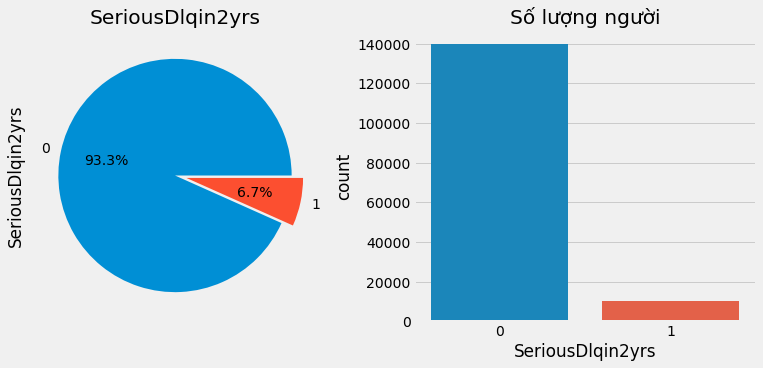

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
finalTrain['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=axes[0])
axes[0].set_title('SeriousDlqin2yrs')
sns.countplot('SeriousDlqin2yrs',data=finalTrain,ax=axes[1])
axes[1].set_title('Số lượng người') #Người đã trải qua vi phạm 90 ngày quá hạn hoặc tệ hơn
plt.show()

In [90]:
train['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

Tỷ lệ của các trường hợp ngoại lệ 0 và 1 được tìm thấy là 93,3% đến 6,7%, xấp xỉ tỷ lệ 14: 1. Do đó, tập dữ liệu rất mất cân đối. Không thể dựa vào điểm chính xác để dự đoán thành công mô hình

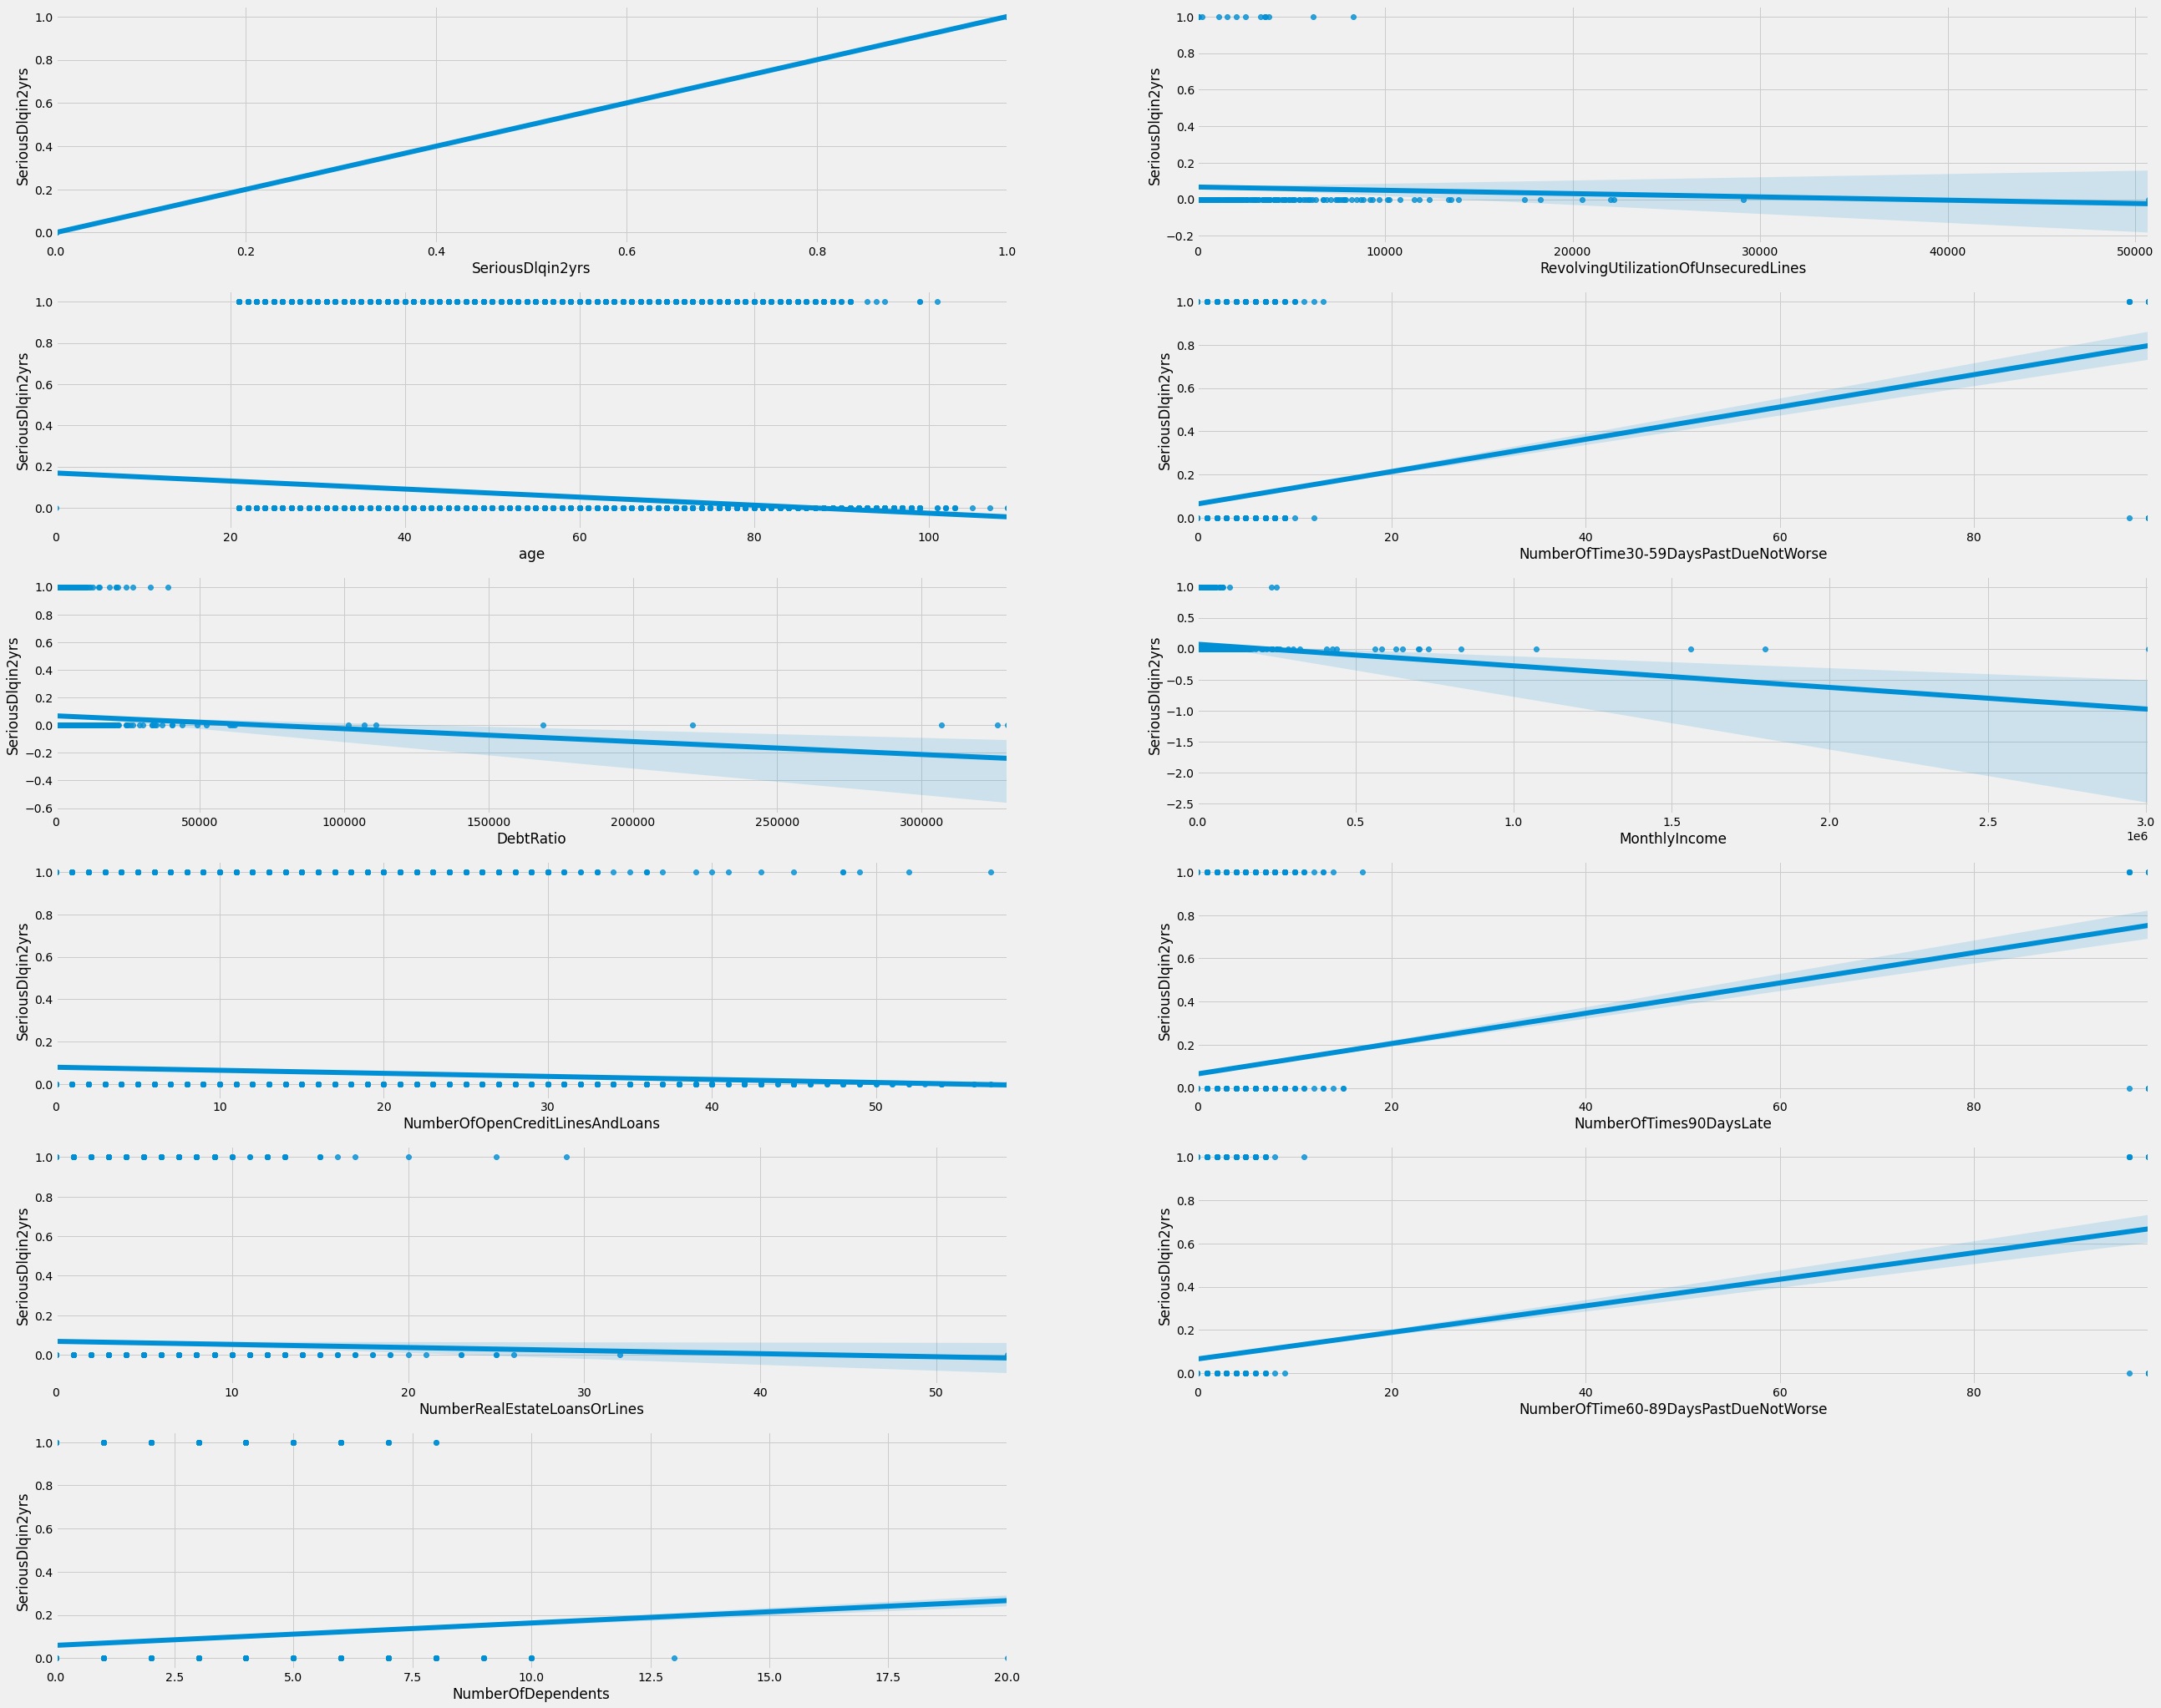

In [91]:
fig = plt.figure(figsize=[40,40])
for col,i in zip(finalTrain.columns,range(1,13)):
    axes = fig.add_subplot(7,2,i)
    sns.regplot(finalTrain[col],finalTrain.SeriousDlqin2yrs,ax=axes) #để vẽ nhiều mối quan hệ tuyến tính trong một tập dữ liệu
plt.show()

Trong các cột NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse và NumberOfTimes90DaysLate, có phạm vi quá hạn vượt quá 90 phổ biến trên cả 3 feature.
Có một số giá trị cao bất thường cho DebtRatio và RevolvingUtilizationOfUnsecuredLines.
Những feature trên có giá trị ngoại lai

In [92]:
print("Những giá trị duy nhất trong những giá trị '30-59 ngày' nhiều hơn hoặc bằng 90:", 
      np.unique(finalTrain[finalTrain['NumberOfTime30-59DaysPastDueNotWorse']>=90] ['NumberOfTime30-59DaysPastDueNotWorse']))
print("Những giá trị duy nhất trong những giá trị '60-89 ngày' khi '30-59 ngày' nhiều hơn hoặc bằng 90:", 
      np.unique(finalTrain[finalTrain['NumberOfTime60-89DaysPastDueNotWorse']>=90] ['NumberOfTime60-89DaysPastDueNotWorse']))
print("Những giá trị duy nhất trong những giá trị '90 ngày' khi '30-59 ngày' nhiều hơn hoặc bằng 90:", 
      np.unique(finalTrain[finalTrain['NumberOfTimes90DaysLate']>=90] ['NumberOfTimes90DaysLate']))
print("Những giá trị duy nhất trong những giá trị '60-89 ngày' khi '30-59 ngày' ít hơn 90: " ,
      np.unique(finalTrain[finalTrain['NumberOfTime60-89DaysPastDueNotWorse']<90] ['NumberOfTime60-89DaysPastDueNotWorse']))
print("Những giá trị duy nhất trong những giá trị '90 ngày' khi '30-59 ngày' ít hơn 90: " ,
      np.unique(finalTrain[finalTrain['NumberOfTimes90DaysLate']<90]['NumberOfTimes90DaysLate']))
print("Tỷ lệ của lớp 1 với những giá trị đặc biệt 96,98: ", 
      round(finalTrain[finalTrain['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs'].sum()*100/
        len(finalTrain[finalTrain['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs']),2),'%')

Những giá trị duy nhất trong những giá trị '30-59 ngày' nhiều hơn hoặc bằng 90: [96 98]

Những giá trị duy nhất trong những giá trị '60-89 ngày' khi '30-59 ngày' nhiều hơn hoặc bằng 90: [96 98]

Những giá trị duy nhất trong những giá trị '90 ngày' khi '30-59 ngày' nhiều hơn hoặc bằng 90: [96 98]

Những giá trị duy nhất trong những giá trị '60-89 ngày' khi '30-59 ngày' ít hơn 90:  [ 0  1  2  3  4  5  6  7  8  9 11]

Những giá trị duy nhất trong những giá trị '90 ngày' khi '30-59 ngày' ít hơn 90:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]

Tỷ lệ của lớp 1 với những giá trị đặc biệt 96,98:  54.65 %


Có thể thấy điều sau rằng khi các bản ghi trong cột 'NumberOfTime30-59DaysPastDueNotWorse' lớn hơn 90, các cột khác ghi lại số lần các khoản thanh toán quá hạn X ngày cũng có cùng giá trị. Chúng tôi sẽ phân loại những nhãn này là nhãn đặc biệt vì tỷ lệ lớp cao bất thường ở mức 54,65%.

Các giá trị 96 và 98 này có thể được xem là lỗi kế toán. Do đó, sẽ thay thế chúng bằng giá trị lớn nhất trước 96, tức là 13, 11 và 17, hoặc là loại bỏ nó

In [93]:
finalTrain.loc[finalTrain['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
finalTrain.loc[finalTrain['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
finalTrain.loc[finalTrain['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 17
print("Các giá trị duy nhất trong 30-59Days", np.unique(finalTrain['NumberOfTime30-59DaysPastDueNotWorse']))
print("Các giá trị duy nhất trong 60-89Days", np.unique(finalTrain['NumberOfTime60-89DaysPastDueNotWorse']))
print("các giá trị duy nhất trong 90Days", np.unique(finalTrain['NumberOfTimes90DaysLate']))

Các giá trị duy nhất trong 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Các giá trị duy nhất trong 60-89Days [ 0  1  2  3  4  5  6  7  8  9 11]

các giá trị duy nhất trong 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]


#### Trên tập test

In [94]:
print("Những giá trị duy nhất trong những giá trị '30-59 ngày' nhiều hơn hoặc bằng 90:", 
      np.unique(finalTest[finalTest['NumberOfTime30-59DaysPastDueNotWorse']>=90] ['NumberOfTime30-59DaysPastDueNotWorse']))
print("Những giá trị duy nhất trong những giá trị '60-89 ngày' khi '30-59 ngày' nhiều hơn hoặc bằng 90:", 
      np.unique(finalTest[finalTest['NumberOfTime60-89DaysPastDueNotWorse']>=90] ['NumberOfTime60-89DaysPastDueNotWorse']))
print("Những giá trị duy nhất trong những giá trị '90 ngày' khi '30-59 ngày' nhiều hơn hoặc bằng 90:", 
      np.unique(finalTest[finalTest['NumberOfTimes90DaysLate']>=90] ['NumberOfTimes90DaysLate']))
print("Những giá trị duy nhất trong những giá trị '30-59 ngày' ít hơn 90: " ,
      np.unique(finalTest[finalTest['NumberOfTime30-59DaysPastDueNotWorse']<90] ['NumberOfTime30-59DaysPastDueNotWorse']))
print("Những giá trị duy nhất trong những giá trị '60-89 ngày' khi '30-59 ngày' ít hơn 90: " ,
      np.unique(finalTest[finalTest['NumberOfTime60-89DaysPastDueNotWorse']<90] ['NumberOfTime60-89DaysPastDueNotWorse']))
print("Những giá trị duy nhất trong những giá trị '90 ngày' khi '30-59 ngày' ít hơn 90: " ,
      np.unique(finalTest[finalTest['NumberOfTimes90DaysLate']<90]['NumberOfTimes90DaysLate']))

Những giá trị duy nhất trong những giá trị '30-59 ngày' nhiều hơn hoặc bằng 90: [96 98]

Những giá trị duy nhất trong những giá trị '60-89 ngày' khi '30-59 ngày' nhiều hơn hoặc bằng 90: [96 98]

Những giá trị duy nhất trong những giá trị '90 ngày' khi '30-59 ngày' nhiều hơn hoặc bằng 90: [96 98]

Những giá trị duy nhất trong những giá trị '30-59 ngày' ít hơn 90:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 19]

Những giá trị duy nhất trong những giá trị '60-89 ngày' khi '30-59 ngày' ít hơn 90:  [0 1 2 3 4 5 6 7 8 9]

Những giá trị duy nhất trong những giá trị '90 ngày' khi '30-59 ngày' ít hơn 90:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 16 17 18]


In [95]:
finalTest.loc[finalTest['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 19
finalTest.loc[finalTest['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 9
finalTest.loc[finalTest['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 18
print("Các giá trị duy nhất trong 30-59Days", np.unique(finalTest['NumberOfTime30-59DaysPastDueNotWorse']))
print("Các giá trị duy nhất trong 60-89Days", np.unique(finalTest['NumberOfTime60-89DaysPastDueNotWorse']))
print("các giá trị duy nhất trong 90Days", np.unique(finalTest['NumberOfTimes90DaysLate']))

Các giá trị duy nhất trong 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 19]

Các giá trị duy nhất trong 60-89Days [0 1 2 3 4 5 6 7 8 9]

các giá trị duy nhất trong 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 16 17 18]


### Tập Train

In [96]:
print('Debt Ratio: \n',finalTrain['DebtRatio'].describe())
print('\nRevolving Utilization of Unsecured Lines: \n',finalTrain['RevolvingUtilizationOfUnsecuredLines'].describe())

Debt Ratio: 

 count    150000.000000

mean        353.005076

std        2037.818523

min           0.000000

25%           0.175074

50%           0.366508

75%           0.868254

max      329664.000000

Name: DebtRatio, dtype: float64



Revolving Utilization of Unsecured Lines: 

 count    150000.000000

mean          6.048438

std         249.755371

min           0.000000

25%           0.029867

50%           0.154181

75%           0.559046

max       50708.000000

Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


In [97]:
quantiles = [0.75,0.8,0.81,0.85,0.9,0.95,0.975,0.99]

for i in quantiles:
    print(i*100,'% quantile of debt ratio is: ',finalTrain.DebtRatio.quantile(i))

75.0 % quantile of debt ratio is:  0.86825377325

80.0 % quantile of debt ratio is:  4.0

81.0 % quantile of debt ratio is:  14.0

85.0 % quantile of debt ratio is:  269.1499999999942

90.0 % quantile of debt ratio is:  1267.0

95.0 % quantile of debt ratio is:  2449.0

97.5 % quantile of debt ratio is:  3489.024999999994

99.0 % quantile of debt ratio is:  4979.040000000037


Quantile bắt đầu tăng nhanh từ 81%, vì vậy sẽ phải kiểm tra outlier từ quantile 81%, nhưng vì dữ liệu chỉ có 150000 mẫu nên sẽ xem xét từ quantile từ 95% và 97.5% để phân tích

In [98]:
finalTrain[finalTrain['DebtRatio'] >= finalTrain['DebtRatio'].quantile(0.95)][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,7501.000000,379.000000
mean,0.055193,0.084433
std,0.228371,0.278403
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Ở đây quan sát được:
Trong số 7501 khách hàng có tỷ lệ nợ lớn hơn 95%, tức là số lần nợ cao hơn thu nhập của họ, chỉ có 379 khách hàng có giá trị Thu nhập hàng tháng.
Giá trị Tối đa cho Thu nhập Hàng tháng là 1 và Tối thiểu là 0, lỗi nhập dữ liệu ?. Hãy kiểm tra xem liệu giá trị Thời gian trễ hạn nghiêm trọng trong 2 năm(SeriousDlqin2yrs) và Thu nhập hàng tháng(MonthlyIncome) có bằng nhau hay không.

In [99]:
finalTrain[(finalTrain["DebtRatio"] > finalTrain["DebtRatio"].quantile(0.95)) & (finalTrain['SeriousDlqin2yrs'] == finalTrain['MonthlyIncome'])]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
50,0,0.818978,73,0,3095.0,0.0,9,0,1,1,0.0
73,0,0.059669,31,0,3162.0,0.0,11,0,2,0,1.0
90,0,0.039388,51,0,15466.0,0.0,7,0,0,0,0.0
326,0,0.013115,43,0,4211.0,0.0,21,0,2,0,2.0
508,0,1.000000,73,0,8500.0,0.0,2,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
147523,0,0.666509,50,0,4351.0,0.0,12,0,2,0,2.0
148258,0,0.211955,31,0,2734.0,0.0,9,0,1,0,1.0
148432,0,0.091785,37,0,2752.0,0.0,7,0,2,0,3.0
149383,0,0.239302,63,0,3153.0,0.0,29,0,1,0,0.0


Do đó, nghi ngờ là đúng và có 331 trong số 379 hàng có Thu nhập hàng tháng bằng với Vi phạm nghiêm trọng trong 2 năm. Do đó, sẽ loại bỏ 331 giá trị ngoại lệ này khỏi phân tích của mình vì các giá trị hiện tại của chúng không hữu ích cho mô hình dự đoán  và sẽ thêm vào độ chệch và phương sai.
Lý do đằng sau điều này, là có 331 hàng trong đó tỷ lệ nợ lớn so với thu nhập của khách hàng và chúng không được xem xét kỹ lưỡng về việc mặc định không phải là lỗi nhập dữ liệu.

In [100]:
finalTrain = finalTrain[-((finalTrain["DebtRatio"] > finalTrain["DebtRatio"].quantile(0.95)) & (finalTrain['SeriousDlqin2yrs'] == finalTrain['MonthlyIncome']))]
finalTrain # đã loại bỏ 331 khách hàng

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


### RevolvingUtilizationOfUnsecuredLines

Trường này về cơ bản thể hiện tỷ lệ số tiền nợ theo hạn mức tín dụng của khách hàng. 
Tỷ lệ cao hơn 1 được coi là một sai số nghiêm trọng. Tỷ lệ bằng 10 về mặt cơ bản cũng có vẻ khả thi, hãy xem có bao nhiêu 
khách hàng trong số này có Revolving Utilization of Unsecured Lines lớn hơn 10.

In [101]:
finalTrain[finalTrain['RevolvingUtilizationOfUnsecuredLines']>10].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,241.000000,241.000000,241.000000,241.000000,241.000000,173.00000,241.000000,241.000000,241.000000,241.000000,228.000000
mean,0.070539,3564.023932,50.630705,0.186722,571.918644,8467.67052,5.763485,0.074689,1.186722,0.087137,0.688596
std,0.256587,5123.802683,14.565389,0.579502,1772.948412,6564.06825,3.114160,0.579711,1.065750,0.559651,1.038659
min,0.000000,11.385230,24.000000,0.000000,0.000800,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,941.000000,39.000000,0.000000,0.217813,4500.00000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2012.000000,48.000000,0.000000,0.402560,7000.00000,5.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,4116.000000,62.000000,0.000000,59.000000,10091.00000,7.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,87.000000,3.000000,21395.000000,44472.00000,21.000000,8.000000,9.000000,7.000000,4.000000


Kiểm tra xem những giá trị của feature sử dụng quay vòng của hạn mức tín dụng không có bảo đảm nào làm ảnh hưởng ít hay nhiều đến feature thời gian trễ hạn nghiêm trọng trong 2 năm bằng cách tính giá tri trung bình của feature thời gian trễ hạn nghiêm trọng trong 2 năm theo giá trị của feature sử dụng quay vòng của hạn mức tín dụng không có bảo đảm.

In [102]:
default_prop = []
for i in range(int(finalTrain["RevolvingUtilizationOfUnsecuredLines"].max())):
    temp_ = finalTrain.loc[finalTrain["RevolvingUtilizationOfUnsecuredLines"] >= i]
    default_prop.append([i, temp_["SeriousDlqin2yrs"].mean()])
default_prop

[[0, 0.0669677755580648],
 [1, 0.3722255548890222],
 [2, 0.14555256064690028],
 [3, 0.09931506849315068],
 [4, 0.08679245283018867],
 [5, 0.07874015748031496],
 [6, 0.07692307692307693],
 [7, 0.0778688524590164],
 [8, 0.07407407407407407],
 [9, 0.07053941908713693],
 [10, 0.07053941908713693],
 [11, 0.07053941908713693],
 [12, 0.06666666666666667],
 [13, 0.058823529411764705],
 [14, 0.058823529411764705],
 [15, 0.05531914893617021],
 [16, 0.05531914893617021],
 [17, 0.05531914893617021],
 [18, 0.05531914893617021],
 [19, 0.05555555555555555],
 [20, 0.05555555555555555],
 [21, 0.05555555555555555],
 [22, 0.05555555555555555],
 [23, 0.05555555555555555],
 [24, 0.05555555555555555],
 [25, 0.05555555555555555],
 [26, 0.05555555555555555],
 [27, 0.05555555555555555],
 [28, 0.05555555555555555],
 [29, 0.05555555555555555],
 [30, 0.05150214592274678],
 [31, 0.05150214592274678],
 [32, 0.05150214592274678],
 [33, 0.05150214592274678],
 [34, 0.05150214592274678],
 [35, 0.05150214592274678],
 [3

Text(0.5, 1.0, 'Tỷ lệ người vi phạm(SeriousDlqin2yrs) khi sử dụng quay vòng của hạn mức tín dụng tối thiểu tăng lên')

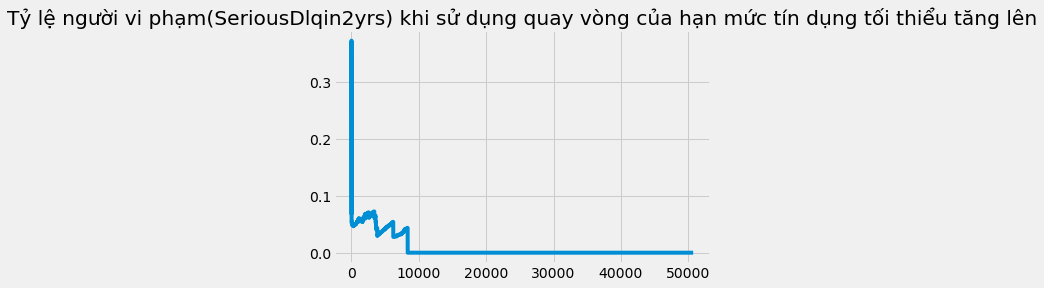

In [103]:
sns.lineplot(x=[i[0] for i in default_prop], y=[i[1] for i in default_prop])
plt.title("Tỷ lệ người vi phạm(SeriousDlqin2yrs) khi sử dụng quay vòng của hạn mức tín dụng tối thiểu tăng lên")

In [104]:
print("Tỷ lệ người vi phạm(SeriousDlqin2yrs) có Tổng số tiền sở hữu không vượt quá tổng hạn mức tín dụng: {}"\
     .format(finalTrain.loc[(finalTrain["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (finalTrain["RevolvingUtilizationOfUnsecuredLines"] <= 1)]["SeriousDlqin2yrs"].mean()))

Tỷ lệ người vi phạm(SeriousDlqin2yrs) có Tổng số tiền sở hữu không vượt quá tổng hạn mức tín dụng: 0.06003334426587952


In [105]:
print("Tỷ lệ người vi phạm(SeriousDlqin2yrs) có tổng số tiền sở hữu không vượt quá hoặc bằng 13 lần tổng hạn mức tín dụng:\n{}"\
     .format(finalTrain.loc[(finalTrain["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (finalTrain["RevolvingUtilizationOfUnsecuredLines"] < 13)]["SeriousDlqin2yrs"].mean()))

Tỷ lệ người vi phạm(SeriousDlqin2yrs) có tổng số tiền sở hữu không vượt quá hoặc bằng 13 lần tổng hạn mức tín dụng:

0.0669807469668275


In [106]:
finalTrain[finalTrain['RevolvingUtilizationOfUnsecuredLines']>13].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,238.000000,238.000000,238.000000,238.000000,238.000000,170.000000,238.000000,238.000000,238.000000,238.000000,225.000000
mean,0.058824,3608.797826,50.634454,0.163866,579.117900,8520.041176,5.689076,0.071429,1.176471,0.071429,0.693333
std,0.235790,5140.423232,14.617658,0.522123,1782.962163,6606.889618,3.032170,0.580214,1.064558,0.542637,1.043346
min,0.000000,14.000000,24.000000,0.000000,0.000800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,951.000000,39.000000,0.000000,0.216587,4608.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2023.500000,48.000000,0.000000,0.391176,7000.000000,5.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,4128.750000,62.000000,0.000000,82.250000,10178.750000,7.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,87.000000,3.000000,21395.000000,44472.000000,21.000000,8.000000,9.000000,7.000000,4.000000


In [107]:
finalTrain = finalTrain[finalTrain['RevolvingUtilizationOfUnsecuredLines']<=13]
finalTrain

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


Loại bỏ những khách hàng có Sử dụng quay vòng của hạn mức tín dụng không có bảo đảm lớn hơn 13. Và dữ liệu còn lại 149431 mẫu

## Xử Lí Missing và Null data

Vì MonthlyIncome là một giá trị số nguyên, chúng tôi sẽ thay thế các giá trị null bằng các giá trị trung vị.
Số người phụ thuộc có thể được mô tả như một biến phân loại, do đó nếu khách hàng có NaN cho số người phụ thuộc, điều đó có nghĩa là họ không có bất kỳ người phụ thuộc nào. Do đó, chúng tôi điền chúng bằng các số không

In [108]:
def missingvalues(data):
    for col in data.columns:
        print('\t%s: %d' % (col,data[col].isna().sum()))
print('Số lượng các giá trị bị mất trong tập train:')
missingvalues(finalTrain)
print('Số lượng các giá trị bị mất trong tập test:')
missingvalues(finalTest)

Số lượng các giá trị bị mất trong tập train:

	SeriousDlqin2yrs: 0

	RevolvingUtilizationOfUnsecuredLines: 0

	age: 0

	NumberOfTime30-59DaysPastDueNotWorse: 0

	DebtRatio: 0

	MonthlyIncome: 29663

	NumberOfOpenCreditLinesAndLoans: 0

	NumberOfTimes90DaysLate: 0

	NumberRealEstateLoansOrLines: 0

	NumberOfTime60-89DaysPastDueNotWorse: 0

	NumberOfDependents: 3911

Số lượng các giá trị bị mất trong tập test:

	SeriousDlqin2yrs: 101503

	RevolvingUtilizationOfUnsecuredLines: 0

	age: 0

	NumberOfTime30-59DaysPastDueNotWorse: 0

	DebtRatio: 0

	MonthlyIncome: 20103

	NumberOfOpenCreditLinesAndLoans: 0

	NumberOfTimes90DaysLate: 0

	NumberRealEstateLoansOrLines: 0

	NumberOfTime60-89DaysPastDueNotWorse: 0

	NumberOfDependents: 2626


In [109]:
def MissingHandler(data):
    DataMissing = data.isnull().sum()*100/len(data)
    DataMissingByColumn = pd.DataFrame({'Tỷ lệ phần trăm dữ liệu NaN':DataMissing})
    DataMissingByColumn.sort_values(by='Tỷ lệ phần trăm dữ liệu NaN',ascending=False,inplace=True)
    return DataMissingByColumn[DataMissingByColumn['Tỷ lệ phần trăm dữ liệu NaN']>0]
MissingHandler(finalTrain)

,Tỷ lệ phần trăm dữ liệu NaN
MonthlyIncome,19.850633
NumberOfDependents,2.617261


In [110]:
def replaceNaN(data):
    data["MonthlyIncome"].fillna(data["MonthlyIncome"].median(), inplace = True)
    data["NumberOfDependents"].fillna(0, inplace = True)
    return data
replaceNaN(finalTrain)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,5400.0,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [111]:
missingvalues(finalTrain)

	SeriousDlqin2yrs: 0

	RevolvingUtilizationOfUnsecuredLines: 0

	age: 0

	NumberOfTime30-59DaysPastDueNotWorse: 0

	DebtRatio: 0

	MonthlyIncome: 0

	NumberOfOpenCreditLinesAndLoans: 0

	NumberOfTimes90DaysLate: 0

	NumberRealEstateLoansOrLines: 0

	NumberOfTime60-89DaysPastDueNotWorse: 0

	NumberOfDependents: 0


In [112]:
MissingHandler(finalTest)

,Tỷ lệ phần trăm dữ liệu NaN
SeriousDlqin2yrs,100.000000
MonthlyIncome,19.805326
NumberOfDependents,2.587116


In [113]:
replaceNaN(finalTest)# trừ SeriousDlqin2yrs

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
101498,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0
101499,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0
101500,NaN,0.081596,70,0,836.000000,5400.0,3,0,0,0,0.0
101501,NaN,0.335457,56,0,3568.000000,5400.0,8,0,2,1,3.0


In [114]:
missingvalues(finalTest)

	SeriousDlqin2yrs: 101503

	RevolvingUtilizationOfUnsecuredLines: 0

	age: 0

	NumberOfTime30-59DaysPastDueNotWorse: 0

	DebtRatio: 0

	MonthlyIncome: 0

	NumberOfOpenCreditLinesAndLoans: 0

	NumberOfTimes90DaysLate: 0

	NumberRealEstateLoansOrLines: 0

	NumberOfTime60-89DaysPastDueNotWorse: 0

	NumberOfDependents: 0


## MA TRẬN TƯƠNG QUAN(CORRELATION MATRIX)

Text(0.5, 1.0, 'Correlation Matrix (HeatMap)')

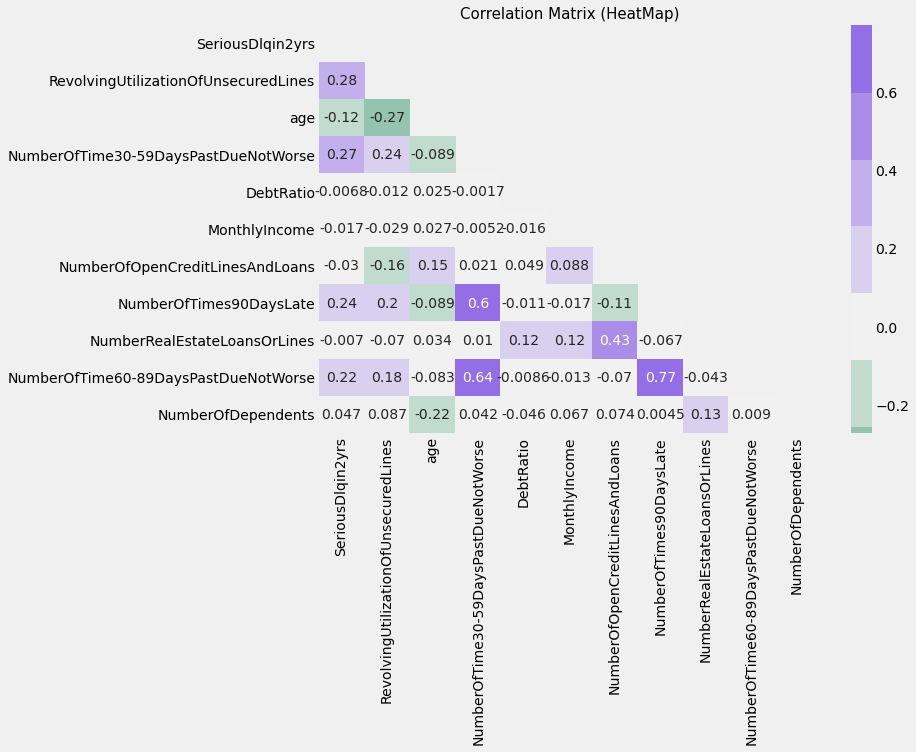

In [115]:
fig = plt.figure(figsize = [10,7])
mask = np.zeros_like(finalTrain.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(finalTrain.corr(), cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9), mask = mask, annot=True, center = 0)
plt.title("Correlation Matrix (HeatMap)", fontsize = 15)

Từ heatmap tương quan ở trên, chúng ta có thể thấy các giá trị tương quan nhất vói SeriousDlqin2yrs là NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse và NumberOfTimes90DaysLate, RevolvingUtilizationOfUnsecuredLines

## Feature Engineering

Kết hợp tập train và tập test để thêm các tính năng trên cả dữ liệu và tiến hành phân tích sâu hơn. Sẽ chia chúng sau trước khi Kiểm tra mô hình.

In [116]:
SeriousDlqIn2Yrs01 = finalTrain['SeriousDlqin2yrs']
SeriousDlqIn2Yrs02 = finalTest['SeriousDlqin2yrs']
finalTrain.drop('SeriousDlqin2yrs', axis = 1 , inplace = True)
finalTest.drop('SeriousDlqin2yrs', axis = 1 , inplace = True)

In [117]:
finalData = pd.concat([finalTrain, finalTest])

finalData.shape

(250934, 10)

Thêm vào một số feature
MonthlyIncomePerPerson: Thu nhập hàng tháng chia cho số người phụ thuộc

MonthlyDebt: Thu nhập hàng tháng nhân với Tỷ lệ Nợ(Debt Ratio)

isRetired: Người có thu nhập hàng tháng bằng 0 và tuổi lớn hơn 65 (Tuổi nghỉ hưu)

RevolvingLines: Sự khác biệt giữa Số lượng Dòng Tín dụng Mở và Khoản cho vay(Number of Open Credit Lines and Loans) và Số Dòng Bất động sản và Khoản cho vay(Number of Real Estate Lines and Loans)

hasRevolvingLines: Nếu RevolvingLines tồn tại thì bằng 1 nếu không thì bằng 0

hasMultipleRealEstates: Nếu Số lượng Bất động sản lớn hơn 2

incomeDivByThousand:Thu nhập hàng tháng chia cho 1000. Có thể có nhiều khả năng là gian lận hoặc nó có thể là dấu hiệu người đó là trong một công việc mới và chưa có một tăng phần trăm lương được nêu ra. Cả hai nhóm đều báo hiệu nguy cơ cao hơn.

In [118]:
finalData['MonthlyIncomePerPerson'] = finalData['MonthlyIncome']/(finalData['NumberOfDependents']+1)
finalData['MonthlyIncomePerPerson'].fillna(0, inplace=True)

finalData['MonthlyDebt'] = finalData['MonthlyIncome']*finalData['DebtRatio']
finalData['MonthlyDebt'].fillna(finalData['DebtRatio'],inplace=True)
finalData['MonthlyDebt'] = np.where(finalData['MonthlyDebt']==0, finalData['DebtRatio'], finalData['MonthlyDebt'])

finalData['isRetired'] = np.where((finalData['age'] > 65), 1, 0)

finalData['RevolvingLines'] = finalData['NumberOfOpenCreditLinesAndLoans']-finalData['NumberRealEstateLoansOrLines']
finalData['hasRevolvingLines']=np.where((finalData['RevolvingLines']>0),1,0)

finalData['hasMultipleRealEstates'] = np.where((finalData['NumberRealEstateLoansOrLines']>=2),1,0)

finalData['incomeDivByThousand'] = finalData['MonthlyIncome']/1000

In [119]:
finalData

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncomePerPerson,MonthlyDebt,isRetired,RevolvingLines,hasRevolvingLines,hasMultipleRealEstates,incomeDivByThousand
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,3040.0,7.323197e+03,0,7,1,1,9.120
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,1300.0,3.168781e+02,0,4,1,0,2.600
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,3042.0,2.589149e+02,0,2,1,0,3.042
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,3300.0,1.189640e+02,0,5,1,0,3.300
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,63588.0,1.584975e+03,0,6,1,0,63.588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101498,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0,1400.0,9.593148e+01,0,5,1,0,1.400
101499,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0,1523.0,7.114066e+03,0,6,1,1,7.615
101500,0.081596,70,0,836.000000,5400.0,3,0,0,0,0.0,5400.0,4.514400e+06,1,3,1,0,5.400
101501,0.335457,56,0,3568.000000,5400.0,8,0,2,1,3.0,1350.0,1.926720e+07,0,6,1,1,5.400


In [120]:
missingvalues(finalData)

	RevolvingUtilizationOfUnsecuredLines: 0

	age: 0

	NumberOfTime30-59DaysPastDueNotWorse: 0

	DebtRatio: 0

	MonthlyIncome: 0

	NumberOfOpenCreditLinesAndLoans: 0

	NumberOfTimes90DaysLate: 0

	NumberRealEstateLoansOrLines: 0

	NumberOfTime60-89DaysPastDueNotWorse: 0

	NumberOfDependents: 0

	MonthlyIncomePerPerson: 0

	MonthlyDebt: 0

	isRetired: 0

	RevolvingLines: 0

	hasRevolvingLines: 0

	hasMultipleRealEstates: 0

	incomeDivByThousand: 0


Bây giờ chúng tôi đã thêm các tính năng mới vào tập dữ liệu của mình. Tiếp theo, chúng tôi sẽ thực hiện kiểm tra độ lệch trên dữ liệu của mình bằng cách phân tích sự phân bố của các cột riêng lẻ và thực hiện Chuyển đổi Box Cox để giảm độ lệch.

## Kiểm tra độ lệch và chuyển đổi Box Cox

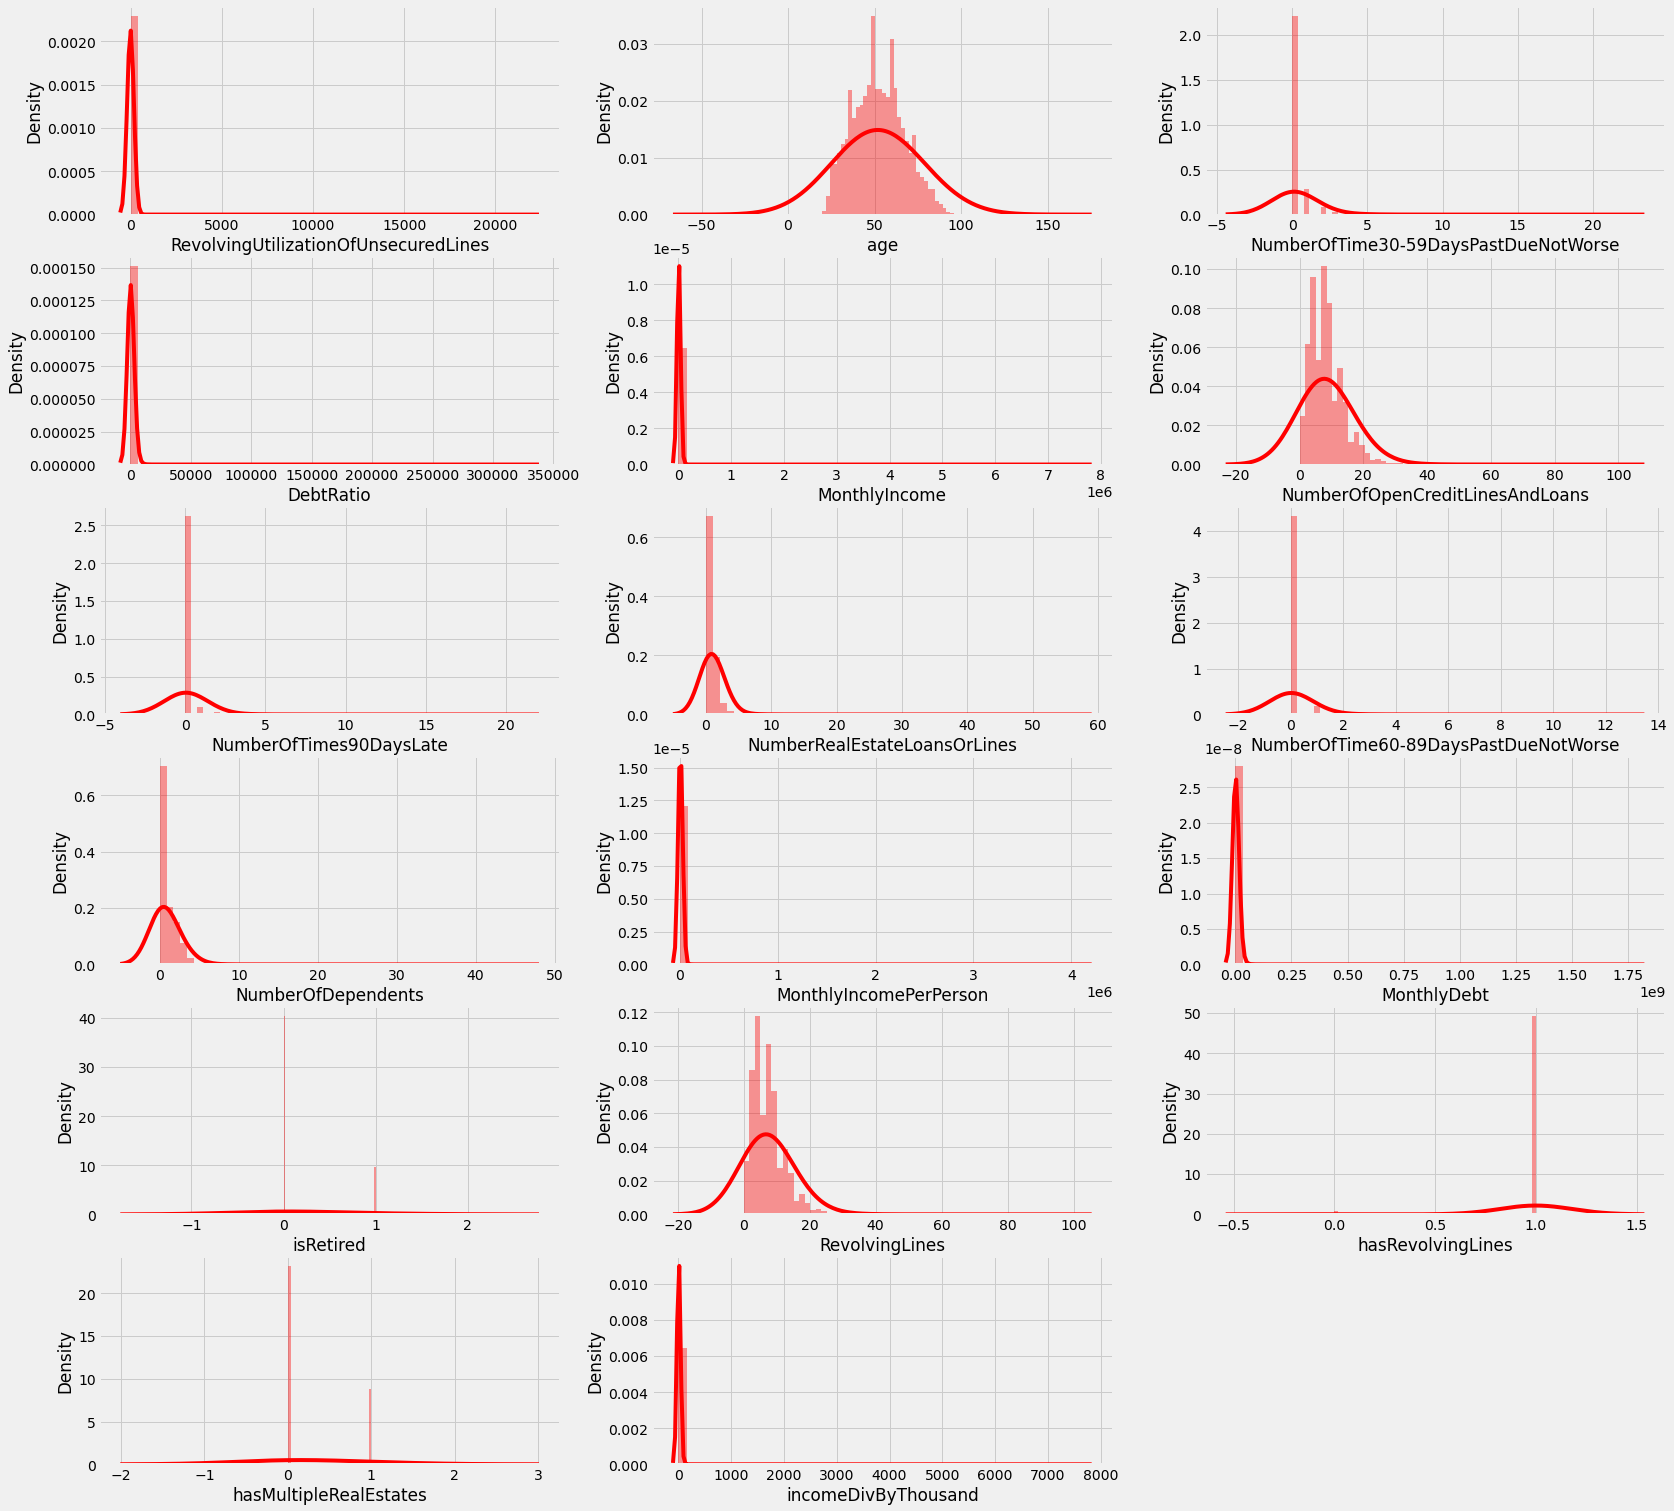

In [121]:
columnList = list(finalData.columns)
columnList

fig = plt.figure(figsize=[25,25])
for col,i in zip(columnList,range(1,19)):
    axes = fig.add_subplot(6,3,i)
    sns.distplot(finalData[col],ax=axes, kde_kws={'bw':1.5}, color='red')
plt.show()

Từ các biểu đồ phân phối ở trên, chúng ta có thể thấy rằng phần lớn dữ liệu của chúng ta bị lệch theo một trong hai hướng. Chúng ta chỉ có thể thấy Tuổi hình thành gần với phân phối chuẩn. Hãy kiểm tra các giá trị độ lệch của mỗi cột

In [122]:
def SkewMeasure(df):
    nonObjectColList = df.dtypes[df.dtypes != 'object'].index
    skewM = df[nonObjectColList].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending = False)
    skewM=pd.DataFrame({'skew':skewM})
    return skewM[abs(skewM)>0.5].dropna()

skewM = SkewMeasure(finalData)
skewM

,skew
MonthlyIncome,218.270205
incomeDivByThousand,218.270205
MonthlyIncomePerPerson,206.221804
MonthlyDebt,98.604981
DebtRatio,92.819627
RevolvingUtilizationOfUnsecuredLines,91.721780
NumberOfTimes90DaysLate,15.097509
NumberOfTime60-89DaysPastDueNotWorse,13.509677
NumberOfTime30-59DaysPastDueNotWorse,9.773995
NumberRealEstateLoansOrLines,3.217055


Độ lệch rất cao đối với tất cả các cột. Chúng tôi sẽ áp dụng Biến đổi Box Cox với λ = 0,15 để giảm độ lệch này.

In [123]:
for i in skewM.index:
    finalData[i] = special.boxcox1p(finalData[i],0.15) #lambda = 0.15
    
SkewMeasure(finalData)

,skew
RevolvingUtilizationOfUnsecuredLines,23.234640
NumberOfTimes90DaysLate,6.787000
NumberOfTime60-89DaysPastDueNotWorse,6.602180
NumberOfTime30-59DaysPastDueNotWorse,3.212010
DebtRatio,1.958314
MonthlyDebt,1.817649
isRetired,1.564456
hasMultipleRealEstates,1.008475
NumberOfDependents,0.947591
incomeDivByThousand,0.708168


Độ lệch đã giảm ở quy mô cao hơn nhiều khi mà Chuyển đổi Box Cox được áp dụng. Hãy kiểm tra lại các ô phân phối cho các cột riêng lẻ:

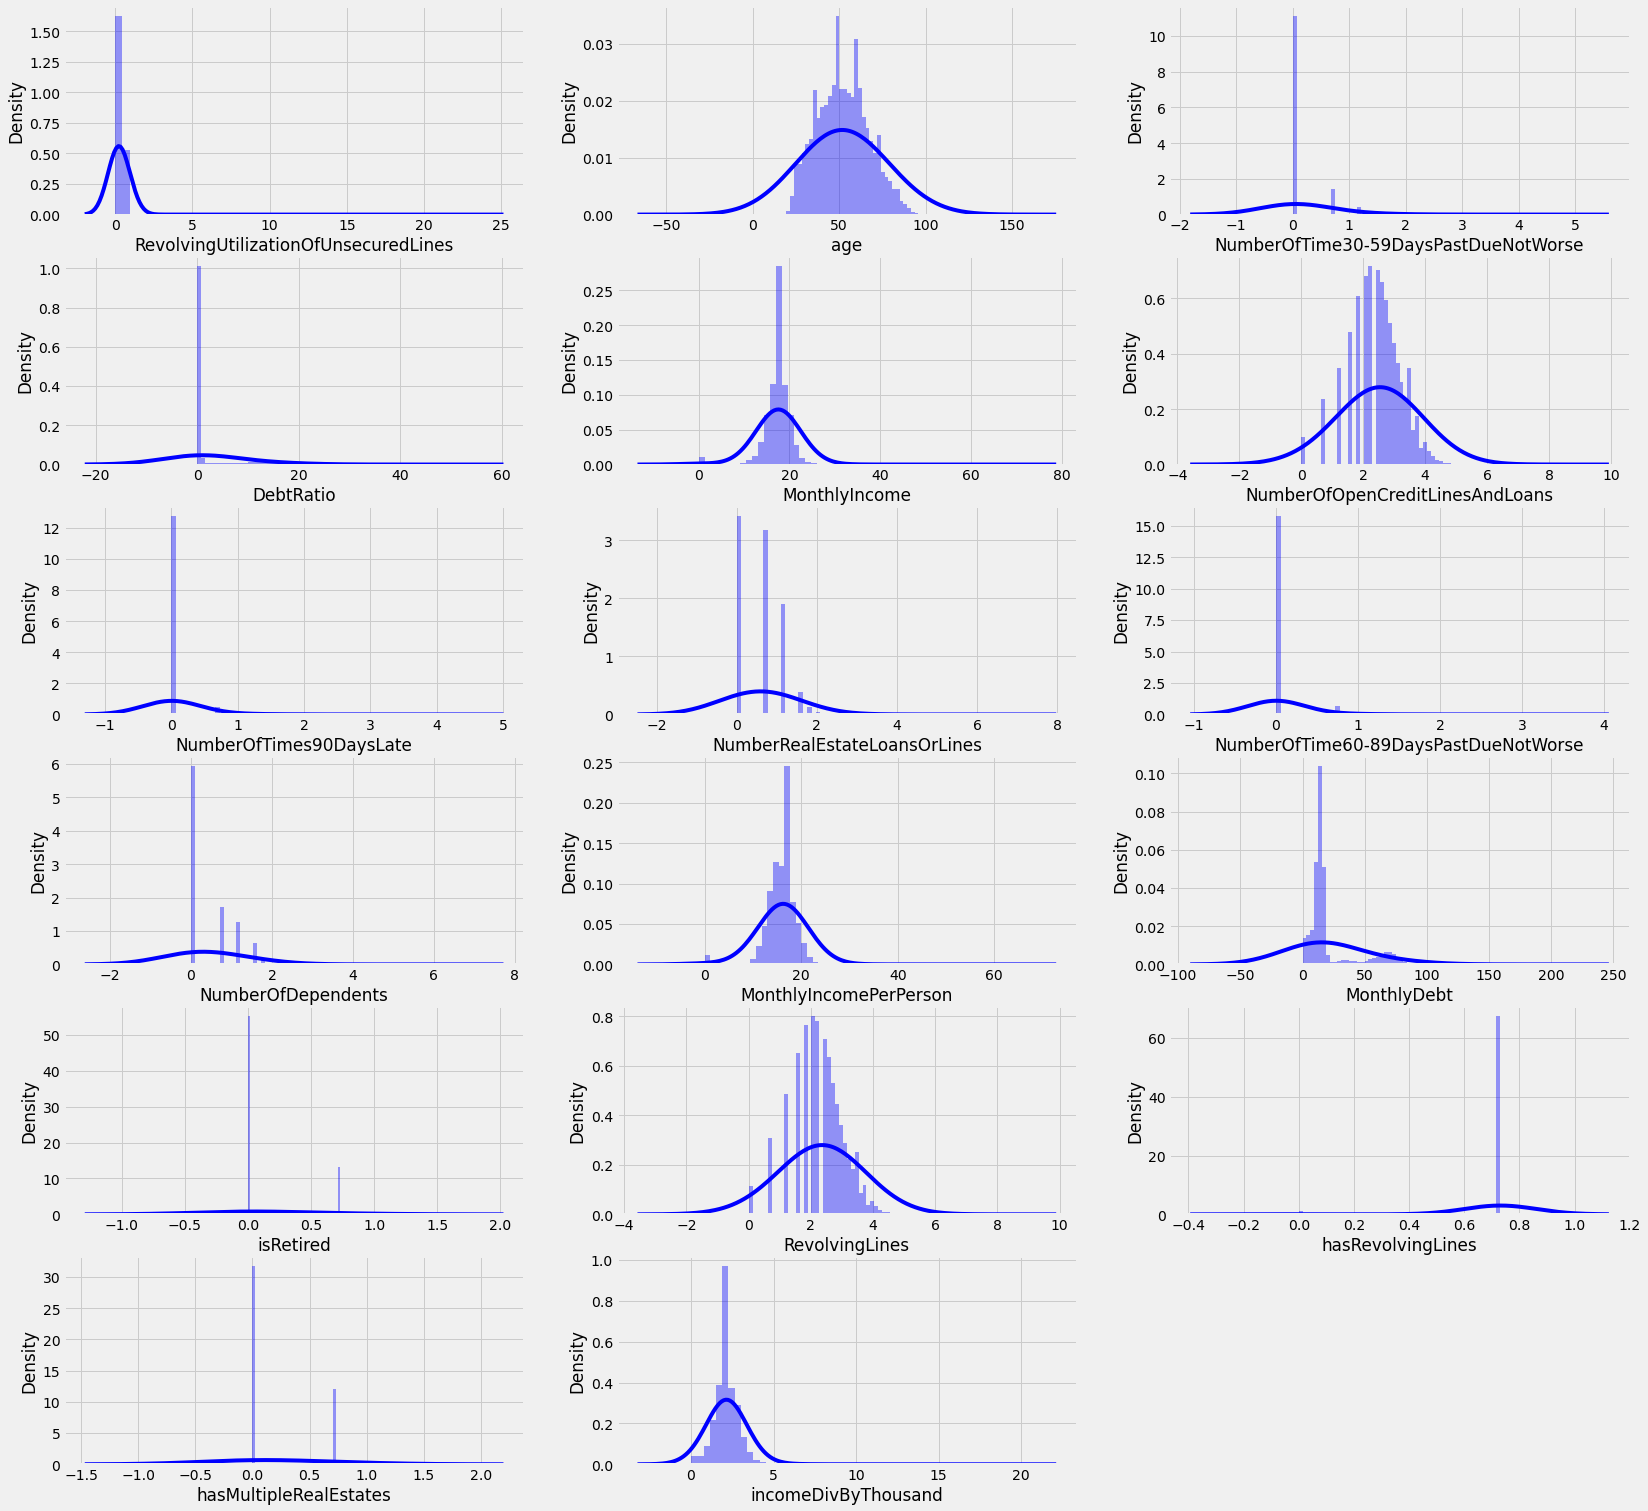

In [124]:
fig = plt.figure(figsize=[25,25])
for col,i in zip(columnList,range(1,19)):
    axes = fig.add_subplot(6,3,i)
    sns.distplot(finalData[col],ax=axes, kde_kws={'bw':1.5}, color='blue')
plt.show()

## Mô Hình

Sẽ chia train và val thành tỷ lệ 70-30. Chia tập final ra thành trainDF với 149431 mẫu và 17 feature và testDF với 101503 mẫu với 17 feature.

In [125]:
trainDF = finalData[:len(finalTrain)]
testDF = finalData[len(finalTrain):]
print(trainDF.shape)
print(testDF.shape)

(149431, 17)

(101503, 17)


In [126]:
xTrain, xTest, yTrain, yTest = model_selection.train_test_split(trainDF.to_numpy(),SeriousDlqIn2Yrs01.to_numpy(),test_size=0.3,random_state=2020)

## Decision tree classification and regression

In [127]:
features = ['RevolvingUtilizationOfUnsecuredLines','age','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse',
            'NumberOfTimes90DaysLate','DebtRatio','MonthlyIncome','DebtRatio','MonthlyIncomePerPerson','NumberOfOpenCreditLinesAndLoans',
            'NumberRealEstateLoansOrLines','NumberOfDependents','RevolvingLines','incomeDivByThousand']
x=trainDF[features]
x1=testDF[features]
#Chuẩn hóa dữ liệu
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(x.to_numpy(),SeriousDlqIn2Yrs01.to_numpy(),test_size=0.3,random_state=2020)
#tạo SMOTE
smote = SMOTE(random_state=2)
#tách dữ liệu
xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

In [128]:
start = datetime.datetime.now()
DTClassifier = DecisionTreeClassifier()
DTClassifier.fit(xtrain_resampled,ytrain_resampled)
end = datetime.datetime.now()
print("\nThời gian chạy trên mô hình Decision Tree là:", end - start)



Thời gian chạy trên mô hình Decision Tree là: 0:00:04.554370


In [129]:
ypred = DTClassifier.predict(xtest)

Text(0, 0.5, 'true positive rate')

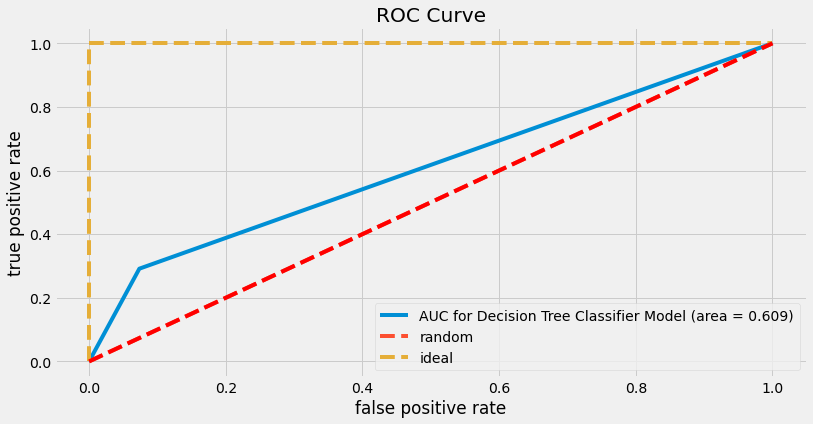

In [130]:
fprDTC, tprDTC, thresholdsDTC = metrics.roc_curve(y_true=ytest, y_score=ypred)
plt.figure(figsize=(12,6))
plt.title('ROC Curve')
sns.lineplot(fprDTC, tprDTC, label="AUC for Decision Tree Classifier Model (area = %.3f)" % metrics.auc(fprDTC, tprDTC))
plt.plot([0,1], [0,1], linestyle='--', label='random')
plt.plot([0,0,1], [0,1,1], linestyle='--', label="ideal")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

Cho thấy tỷ lẻ TP với FP và AUC bằng 0.614, tức là có 61,4% nhãn 1 được dự đoán đúng.

Test Accuracy: 0.8844300691501227


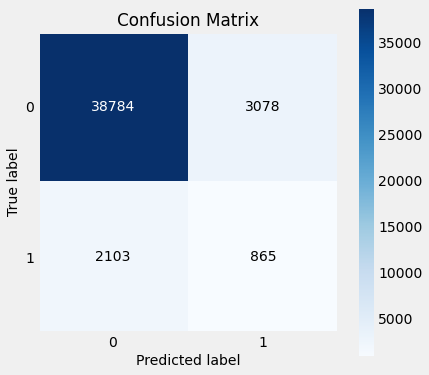

In [131]:
skplt.metrics.plot_confusion_matrix(ytest,ypred,figsize=(6,6))
print("Test Accuracy:",DTClassifier.score(xtest, ytest))

In [132]:
print(metrics.classification_report(ytest, ypred))
print("Accuracy:",metrics.accuracy_score(ytest, ypred))

              precision    recall  f1-score   support



           0       0.95      0.93      0.94     41862

           1       0.22      0.29      0.25      2968



    accuracy                           0.88     44830

   macro avg       0.58      0.61      0.59     44830

weighted avg       0.90      0.88      0.89     44830



Accuracy: 0.8844300691501227


Mô hình DTC có f1-score thấp và cả recall và precision đều thấp vì vậy mô hình này không dự đoán được nhiều label 1 thật. Mô hình bị overfit

In [133]:
DecisionTreeClassifierMetrics = pd.DataFrame({'Model': 'DecisionTreeClassifier', 
                            'MSE': round(metrics.mean_squared_error(ytest, ypred)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(ytest, ypred)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(ytest, ypred)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(ytest, ypred)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(ytest, ypred)*100),2),
                            'Accuracy Train' : round(DTClassifier.score(xtrain, ytrain) * 100,2),
                            'Accuracy Test' : round(DTClassifier.score(xtest, ytest) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(ytest, ypred, beta=2)*100,2)},index=[1])

DecisionTreeClassifierMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
1,DecisionTreeClassifier,11.56,3.4,11.56,5.55,2.36,99.96,88.44,27.35


In [134]:
features = ['RevolvingUtilizationOfUnsecuredLines','age','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse',
            'NumberOfTimes90DaysLate','DebtRatio','MonthlyIncome','DebtRatio','MonthlyIncomePerPerson','NumberOfOpenCreditLinesAndLoans',
            'NumberRealEstateLoansOrLines','NumberOfDependents','RevolvingLines','incomeDivByThousand']
x=trainDF[features]
x1=testDF[features]
#Chuẩn hóa dữ liệu
x_train, x_test, y_train, y_test = model_selection.train_test_split(x.to_numpy(),SeriousDlqIn2Yrs01.to_numpy(),test_size=0.3,random_state=2020)
# tạo StandardScaler và fit_trainsform
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.fit_transform(x_test)
#tạo SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=10)
#tách dữ liệu
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_std, y_train)

In [135]:
param_range = [0.001, 0.01, 0.1, 1.0, 10, 100]
penalty = ['l1', 'l2']
param_grid = [{"C":param_range, "penalty":penalty}]
start = datetime.datetime.now()
logmodel = LogisticRegression()
gs = GridSearchCV(estimator=logmodel, param_grid=param_grid, scoring="recall", cv=10, n_jobs=-1)
gs = gs.fit(x_train_resampled, y_train_resampled)
end = datetime.datetime.now()
print(gs.best_score_.round(3))
print(gs.best_params_)
print("\nThời gian chạy trên mô hình Logistic Regression là:", end - start)

0.747

{'C': 1.0, 'penalty': 'l2'}



Thời gian chạy trên mô hình Logistic Regression là: 0:01:12.863237


In [136]:
bestEstimatorGS= gs.best_estimator_
print('Test accuracy: %.3f' % bestEstimatorGS.score(x_test_std, y_test))

Test accuracy: 0.801


In [137]:
y_pred = bestEstimatorGS.predict(x_test_std)
y_pred_train = bestEstimatorGS.predict(x_train_std)
#Xác nhận mô hình
print("*accuracy_train = %.3f" % metrics.accuracy_score(y_true=y_train, y_pred=y_pred_train))
print("accuracy = %.3f" % metrics.accuracy_score(y_true=y_test, y_pred=y_pred))

print("*precision_train = %.3f" % metrics.precision_score(y_true=y_train, y_pred=y_pred_train))
print("precision = %.3f" % metrics.precision_score(y_true=y_test, y_pred=y_pred))

print("*recall_train = %.3f" % metrics.recall_score(y_true=y_train, y_pred=y_pred_train))
print("recall = %.3f" % metrics.recall_score(y_true=y_test, y_pred=y_pred))

print("*f1_score_train = %.3f" % metrics.f1_score(y_true=y_train, y_pred=y_pred_train))
print("f1_score = %.3f" % metrics.f1_score(y_true=y_test, y_pred=y_pred))

*accuracy_train = 0.800

accuracy = 0.801

*precision_train = 0.215

precision = 0.213

*recall_train = 0.743

recall = 0.745

*f1_score_train = 0.334

f1_score = 0.331


Text(0, 0.5, 'true positive rate')

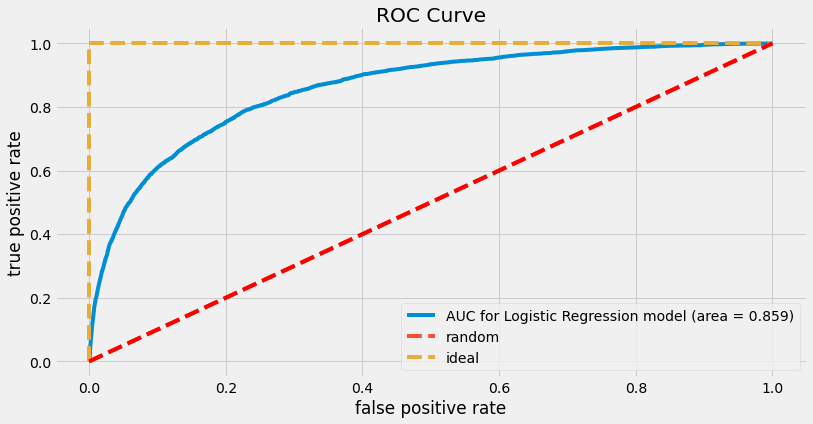

In [138]:
# ROC curve và AUC
y_score = bestEstimatorGS.predict_proba(x_test_std)[:, 1]

fprLR, tprLR, thresholdsLR = metrics.roc_curve(y_true=y_test, y_score=y_score)
# Visualization
plt.figure(figsize=(12,6))
plt.title('ROC Curve')
sns.lineplot(fprLR, tprLR, label="AUC for Logistic Regression model (area = %.3f)" % metrics.auc(fprLR, tprLR))
plt.plot([0,1], [0,1], linestyle='--', label='random')
plt.plot([0,0,1], [0,1,1], linestyle='--', label="ideal")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

Cho thấy tỷ lẻ TP với FP và AUC bằng 0.859, tức là có 85,9% nhãn 1 được dự đoán đúng

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

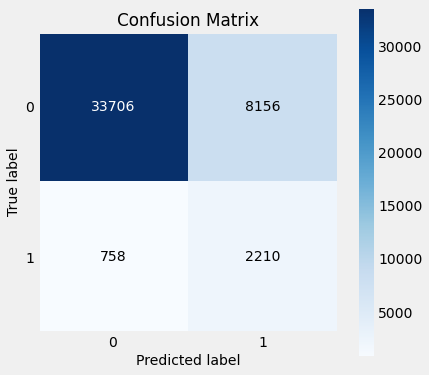

In [139]:
skplt.metrics.plot_confusion_matrix(y_test,y_pred,figsize=(6,6))

In [140]:
print(metrics.classification_report(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support



           0       0.98      0.81      0.88     41862

           1       0.21      0.74      0.33      2968



    accuracy                           0.80     44830

   macro avg       0.60      0.77      0.61     44830

weighted avg       0.93      0.80      0.85     44830



Accuracy: 0.8011599375418247


Độ chính xác accuracy bằng 0.80 khá cao nhưng trong tập dữ liệu mất cân bằng chúng ta quan tâm đến f1-score hay recall hay precision nếu TP hiếm hay label 1 hiếm. Precision khác thấp điều đó cho thấy các mẫu được dự đoán là 1 không phải là label 1 thật và recall bằng 0.74 khá cao cho thấy dự đoán được nhiều label 1

In [141]:
LRegressionMetrics = pd.DataFrame({'Model': 'LogisticRegression', 
                            'MSE': round(metrics.mean_squared_error(y_test, y_pred)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(y_test, y_pred)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(y_test, y_pred)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(y_test, y_pred)*100),2),
                            'Accuracy Train' : round(bestEstimatorGS.score(x_train, y_train) * 100,2),     
                            'Accuracy Test' : round(bestEstimatorGS.score(x_test, y_test) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(y_test, y_pred, beta=2)*100,2)},index=[1])

LRegressionMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
1,LogisticRegression,19.88,4.46,19.88,9.55,3.09,93.26,93.36,49.69


## LightGBM

Điều chỉnh siêu tham số

In [142]:
lgbAttributes = lgb.LGBMClassifier(objective='binary', n_jobs=-1, random_state=2020, importance_type='gain')

lgbParameters = {
    'max_depth' : [2,3,4,5],
    'learning_rate': [0.05, 0.1,0.125,0.15],
    'colsample_bytree' : [0.2,0.4,0.6,0.8,1],
    'n_estimators' : [400,500,600,700,800,900],
    'min_split_gain' : [0.15,0.20,0.25,0.3,0.35], 
    'subsample': [0.6,0.7,0.8,0.9,1],
    'min_child_weight': [6,7,8,9,10],
    'scale_pos_weight': [10,15,20],
    'min_data_in_leaf' : [100,200,300,400,500,600,700,800,900],
    'num_leaves' : [20,30,40,50,60,70,80,90,100]
}

lgbModel = model_selection.RandomizedSearchCV(lgbAttributes, param_distributions = lgbParameters, cv = 5, random_state=2020)

lgbModel.fit(xTrain,yTrain.flatten(),feature_name=trainDF.columns.to_list())

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400



RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(importance_type='gain',
                                            objective='binary',
                                            random_state=2020),
                   param_distributions={'colsample_bytree': [0.2, 0.4, 0.6, 0.8,
                                                             1],
                                        'learning_rate': [0.05, 0.1, 0.125,
                                                          0.15],
                                        'max_depth': [2, 3, 4, 5],
                                        'min_child_weight': [6, 7, 8, 9, 10],
                                        'min_data_in_leaf': [100, 200, 300, 400,
                                                             500, 600, 700, 800,
                                                             900],
                                        'min_split_gain': [0.15, 0.2, 0.25, 0.3,
                                     

In [143]:
bestEstimatorLGB = lgbModel.best_estimator_
bestEstimatorLGB

LGBMClassifier(colsample_bytree=0.4, importance_type='gain', max_depth=5,
               min_child_weight=6, min_data_in_leaf=600, min_split_gain=0.25,
               n_estimators=900, num_leaves=50, objective='binary',
               random_state=2020, scale_pos_weight=10, subsample=0.9)

Lưu công cụ ước tính tốt nhất từ RandomSearchCV

In [144]:
start = datetime.datetime.now()
bestEstimatorLGB = lgb.LGBMClassifier(colsample_bytree=0.4, importance_type='gain', max_depth=5,
               min_child_weight=6, min_data_in_leaf=600, min_split_gain=0.25,
               n_estimators=900, num_leaves=50, objective='binary',
               random_state=2020, scale_pos_weight=10, subsample=0.9).fit(xTrain,yTrain.flatten(),feature_name=trainDF.columns.to_list())
end = datetime.datetime.now()
print("\nThời gian chạy trên mô hình Lgbm: ", end-start)



Thời gian chạy trên mô hình Lgbm:  0:00:09.982793


In [145]:
yPredLGB = bestEstimatorLGB.predict_proba(xTest)
yPredLGB = yPredLGB[:,1]

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

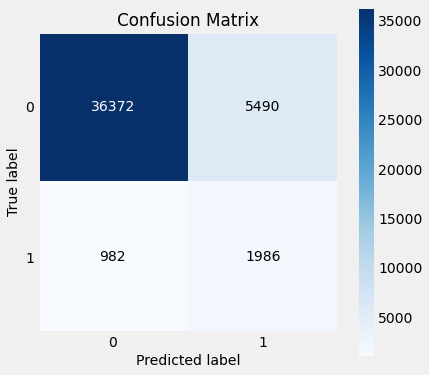

In [146]:
skplt.metrics.plot_confusion_matrix(yTest,yTestPredLGB,figsize=(6,6))

In [147]:
yTestPredLGB = bestEstimatorLGB.predict(xTest)
print(metrics.classification_report(yTest,yTestPredLGB))

              precision    recall  f1-score   support



           0       0.97      0.87      0.92     41862

           1       0.27      0.67      0.38      2968



    accuracy                           0.86     44830

   macro avg       0.62      0.77      0.65     44830

weighted avg       0.93      0.86      0.88     44830




Độ chính xác accuracy bằng 0.86 khá cao nhưng trong tập dữ liệu mất cân bằng chúng ta quan tâm đến f1-score hay recall hay precision nếu TP hiếm hay label 1 hiếm. Precision khác thấp điều đó cho thấy các mẫu được dự đoán là 1 không phải là label 1 thật và recall bằng 0.67 khá cao cho thấy dự đoán được nhiều label 1. Sau đây là ma trận nhầm lẫn sẽ chỉ rõ điều đó hơn.

In [148]:
LGBMMetrics = pd.DataFrame({'Model': 'LightGBM', 
                            'MSE': round(metrics.mean_squared_error(yTest, yTestPredLGB)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(yTest, yTestPredLGB)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(yTest, yTestPredLGB)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(yTest, yTestPredLGB)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(yTest, yTestPredLGB)*100),2),
                            'Accuracy Train' : round(bestEstimatorLGB.score(xTrain, yTrain) * 100,2),
                            'Accuracy Test' : round(bestEstimatorLGB.score(xTest, yTest) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(yTest, yTestPredLGB, beta=2)*100,2)},index=[1])

LGBMMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
1,LightGBM,14.44,3.8,14.44,6.94,2.63,86.55,85.56,51.32


## ROC AUC

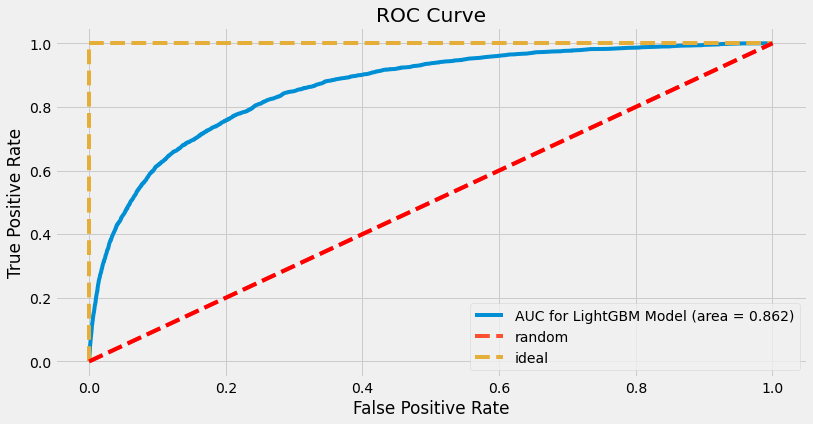

In [149]:
fprLGBM, tprLGBM, thresholdsLGBM = metrics.roc_curve(yTest,yPredLGB)
rocAuc = metrics.auc(fprLGBM, tprLGBM)
plt.figure(figsize=(12,6))
plt.title('ROC Curve')
sns.lineplot(fprLGBM, tprLGBM, label = 'AUC for LightGBM Model (area = %.3f)' % rocAuc)
plt.plot([0,1], [0,1], linestyle='--', label='random')
plt.plot([0,0,1], [0,1,1], linestyle='--', label="ideal")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Cho thấy tỷ lẻ TP với FP và AUC bằng 0.862, tức là có 86,2% nhãn 1 được dự đoán đúng

## FEATURE Quan Trọng

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

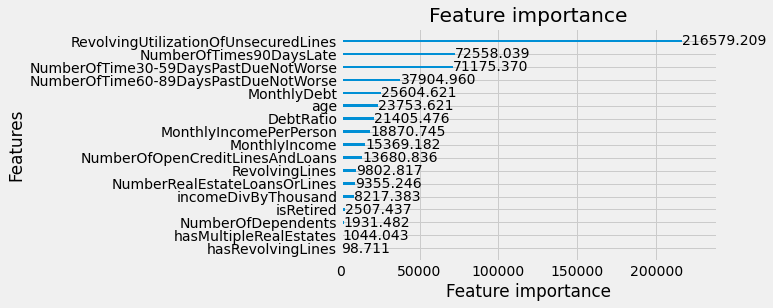

In [150]:
lgb.plot_importance(bestEstimatorLGB, importance_type='gain')

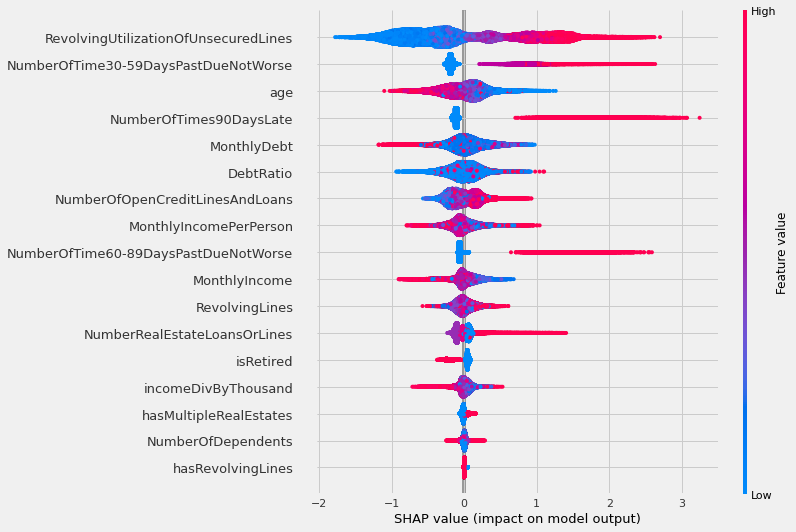

In [151]:
X = pd.DataFrame(xTrain, columns=trainDF.columns.to_list())

explainer = shap.TreeExplainer(bestEstimatorLGB)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values[1], X)

## SO SÁNH CÁC MÔ HÌNH

Text(0, 0.5, 'true positive rate')

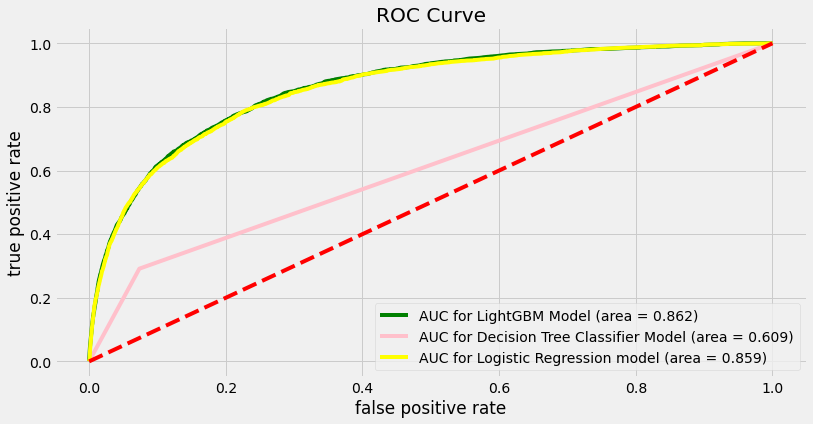

In [152]:
# Visualization
plt.figure(figsize=(12,6))
plt.title('ROC Curve')
sns.lineplot(fprLGBM, tprLGBM, label = 'AUC for LightGBM Model (area = %.3f)' % rocAuc, color='green')
sns.lineplot(fprDTC, tprDTC, label="AUC for Decision Tree Classifier Model (area = %.3f)" % metrics.auc(fprDTC, tprDTC), color='pink')
sns.lineplot(fprLR, tprLR, label="AUC for Logistic Regression model (area = %.3f)" % metrics.auc(fprLR, tprLR), color='yellow')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

In [153]:
frames = [LGBMMetrics, DecisionTreeClassifierMetrics, LRegressionMetrics]
TrainingResult = pd.concat(frames)
TrainingResult.T

,1,1,1
Model,LightGBM,DecisionTreeClassifier,LogisticRegression
MSE,14.44,11.56,19.88
RMSE,3.8,3.4,4.46
MAE,14.44,11.56,19.88
MSLE,6.94,5.55,9.55
RMSLE,2.63,2.36,3.09
Accuracy Train,86.55,99.96,93.26
Accuracy Test,85.56,88.44,93.36
F-Beta Score (β=2),51.32,27.35,49.69


## Kết quả

In [154]:
lgbProbs = bestEstimatorLGB.predict_proba(testDF)
lgbDF = pd.DataFrame({'ID': testIndex, 'Probability': lgbProbs[:,1]})
lgbDF.to_csv('submissionLGBM.csv', index=False)

In [155]:
lrProbs = bestEstimatorGS.predict_proba(x1)
lrDF = pd.DataFrame({'ID': testIndex, 'Probability': lrProbs[:,1]})
lrDF.to_csv('submissionLR.csv', index=False)